<a href="https://colab.research.google.com/github/dwjang0902/ExampleNew/blob/master/Data_prediction_stock_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

요청 URL = http://finance.naver.com/item/sise_day.nhn?code= 049430


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


 length =  986
<class 'numpy.ndarray'> (493, 2, 6)
<class 'numpy.ndarray'> (493, 2, 1)
[[-2.26576612]
 [-2.17845913]]
[[1.00824573]
 [0.87728525]]


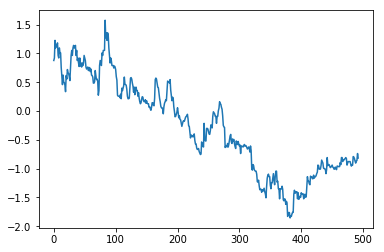

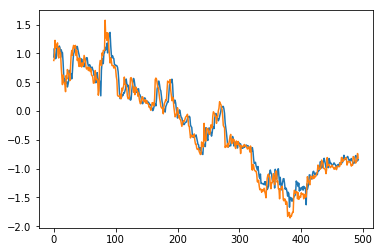

'\n#------------------------------------------------------------------------------------------\n\n\nplt.title("Forecast vs Actual", fontsize = 14)\nplt.plot( pd.Series(np.ravel(y_test)), "bo", markersize = 10, label ="Actual")\n\nplt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize = 10, label = "Forecast")\nplt.legend(loc = " upper right")\nplt.xlabel("Time Periods")\nplt.show\n        \n'

In [48]:
#참조 : https://coolingoff.tistory.com/category/%5B%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%5D/Tensorflow
#       https://sshkim.tistory.com/153
#       https://www.youtube.com/watch?v=odMGK7pwTqY
# Deep Learning ZerotoAll
#---------------------------------------------------------
#주가 데이터 읽어오기
#---------------------------------------------------------
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

tf.reset_default_graph() # 중요한 부분이다; 이것이 없으면 런타임을 항상 리셋 해 주어야 한다.

#-------------------------------------------------------------------------------
# 한국거래소에서 종목코드 가져오기
code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]

# 종목코드가 6자리이기 때문에 6자리를 맞춰주기 위해 설정해줌 
code_df.종목코드 = code_df.종목코드.map('{:06d}'.format)

# 우리가 필요한 것은 회사명과 종목코드이기 때문에 필요없는 column들은 제외해준다. 
code_df = code_df[['회사명', '종목코드']]

# 한글로된 컬럼명을 영어로 바꿔준다. 
code_df = code_df.rename(columns={'회사명': 'name', '종목코드': 'code'}) 
code_df.head()
#-------------------------------------------------------------------------------


# 종목 이름을 입력하면 종목에 해당하는 코드를 불러와 
# 네이버 금융(http://finance.naver.com)에 넣어줌 
def get_url(item_name, code_df): 
    code = code_df.query("name=='{}'".format(item_name))['code'].to_string(index=False) 
    url = 'http://finance.naver.com/item/sise_day.nhn?code={code}'.format(code=code) 
    
    print("요청 URL = {}".format(url)) 
    return url, code

# 신라젠의 일자데이터 url 가져오기 

item_name='코메론' 
url, code = get_url(item_name, code_df)
#print(type(code))
# 왜 이렇게 해야 동작하는지 잘 모르겠다.
code = np.int(code)
code = str(code)
code = code.zfill(6)

code_num = code
#print(url)

# 일자 데이터를 담을 df라는 DataFrame 정의 
df = pd.DataFrame()


# 1페이지에서 20페이지의 데이터만 가져오기 
for page in range(1, 100): 
#    pg_url = '{url}&page={page}'.format(url=url, page=page) # 동작을 않는다, 이유를 모르겠다 ???
    pg_url = 'http://finance.naver.com/item/sise_day.nhn?code=' + code_num + '&page='+ str(page)
#    print(pg_url)
#    df = pd.read_html(pg_url)
    df = df.append(pd.read_html(pg_url, header=0)[0], ignore_index=True)
 
# NaN 데이타 제거
df = df.dropna(axis = 0)

# 한글로 된 컬럼명을 영어로 바꿔줌 
df = df.rename(columns= {'날짜': 'date', '종가': 'close', '전일비': 'diff', '시가': 'open', '고가': 'high', '저가': 'low', '거래량': 'volume'}) 

# 데이터의 타입을 int형으로 바꿔줌 
#df[['close', 'diff', 'open', 'high', 'low', 'volume']]  = df[['close', 'diff', 'open', 'high', 'low', 'volume']].astype(float) 

# 일자(date)를 기준으로 오름차순 정렬 
df = df.sort_values(by=['date'], ascending=True) 

# 상위 5개 데이터 확인
#print( df.tail(10))

#plt.plot(df["close"].to_numpy())
#plt.show()

#print(df.dtypes) #object

#------------------------------------------------------------
# 예측하기 by RNN
#------------------------------------------------------------
input_data = df.as_matrix()[:, 1:7].astype(int) #input_data = df.to_numpy()[:, 1:7].astype(int)
#print(type(input_data), input_data.shape)
#print(input_data[0])


# 데이터 정규화
#-----------------------------
from sklearn.preprocessing import scale, robust_scale, minmax_scale, maxabs_scale

input_data = scale(input_data)
input_data = np.asarray(input_data)

"""
from sklearn.preprocessing import normalize
input_data = normalize(input_data, axis = 0, norm = 'l1') #column normalize
input_data = np.asarray(input_data)
#print(type(input_data), input_data.shape)
#print(input_data[0])
"""

# RNN 입력데이터 준비
#-------------------------------
def gen_xy_data(input_data, seq_len, pred_step = 1) :
        x_data = []
        y_data = []
        length = input_data.shape[0] - seq_len - pred_step+1
        print(" length = ", length)
        for i in range(length) :
            x = input_data[i:i+seq_len]
            y = input_data[i+pred_step: i+seq_len+pred_step]
            x_data.append(x)
            y_data.append(y)
        return x_data, y_data

seq_len   = 2
pred_step = 3
#x_data = [batch_size, seq_len, input_dim]; y_data = [batch_size, seq_len, output_dim]
x_data, y_data = gen_xy_data(input_data, seq_len, pred_step)
x_data = np.asarray(x_data)
y_data = np.asarray(y_data)



#print(x_data[0:1])
#print(y_data[0:1])

def train_test_split_self(x_data, y_data, test_size=0.50, self = 1, random_state = None):
    if self == 0 : 
        x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.50, random_state = random_state)
    else :
        train_size = int(x_data.shape[0]*test_size)
        x_train = x_data[0:train_size]; y_train = y_data[0:train_size]
        x_test = x_data[train_size:]; y_test = y_data[train_size:]
    return x_train, x_test, y_train, y_test

# 데이터 분리(트레이닝, 테스트)
x_train, x_test, y_train, y_test = train_test_split_self(x_data, y_data, test_size=0.50, random_state= None)
    
y_train = y_train[:,:,0]
y_test = y_test[:,:,0]
y_train = np.expand_dims(y_train, axis = 2)
y_test = np.expand_dims(y_test, axis = 2)

print(type(x_train), x_train.shape)
print(type(y_train), y_train.shape)
print(y_train[0])
print(y_test[0])
plt.plot(y_test[:,1])

#print(len(x_train), len(x_test))

#Parameter
#----------------------------
input_dim = x_train.shape[2] #6
output_dim = 1 # 종가만 예측하는 것으로 한다
seq_len = seq_len
hidden_size = 10


#Model
X = tf.placeholder(tf.float32, [None, seq_len, input_dim])
Y = tf.placeholder(tf.float32, [None, seq_len, output_dim])

# 참조 : https://github.com/tensorflow/tensorflow/issues/16186
def lstm_cell():
   lstm = tf.contrib.rnn.BasicLSTMCell(hidden_size, forget_bias=1.0)
   return lstm
cells = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(1)])
outputs, _states = tf.nn.dynamic_rnn(cells, X, dtype = tf.float32) # 출력
#outputs = [batch_size, seq_len, hidden_size  ]

# 변수 정의 및 출력 reshape
softmax_w = tf.Variable(tf.random_normal(shape=[hidden_size, output_dim]), dtype=tf.float32)
softmax_b = tf.Variable(tf.random_normal(shape=[output_dim]), dtype=tf.float32)

output = tf.reshape(outputs, [-1, hidden_size]) #[batch_size*seq_len, hidden_size]


# 최종 출력값을 설정합니다; 일종의 dense_layer 추가 ...
logits = tf.matmul(output, softmax_w) + softmax_b # logits : [batch_size * seq_length, output_dim]
logits = tf.reshape(logits ,[-1, seq_len, output_dim]) #reshape
predictions = logits
#predictions  = tf.nn.softmax(logits) # 이것은 잘 동작하지 않는다.


# 이 경우에는 target도 아래와 같이 [batch_size * seq_length, output_size]로 바꾸어 주어야 한다
loss = tf.losses.mean_squared_error(predictions = logits, labels = Y,  weights=1.0)
loss_total = tf.reduce_mean(loss)  

learning_rate = 0.001


optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()


epoches = 1000

#---------------------------------------------------------------------------------------
with tf.Session() as sess :
    sess.run(init)
    for ep in range(epoches) :
#        sess.run(training_op, feed_dict = { x : x_batches, y: y_batches})
        sess.run(training_op, feed_dict = { X : x_train, Y: y_train})
        
        if ep % 10 == 0 :
            mse = loss.eval(feed_dict = { X : x_test, Y: y_test})
#            print(ep, "\MSE ", mse)


    y_pred = sess.run(predictions, feed_dict = {X: x_test})
#    print(" Prediction = \n ", np.squeeze(y_pred))
plt.figure(2)
plt.plot(np.squeeze(y_pred)[:,1]) # 임시 ...
#plt.figure(3)
plt.plot(np.squeeze(y_test)[:,1]) # 임시 ...
plt.show()
"""
#------------------------------------------------------------------------------------------


plt.title("Forecast vs Actual", fontsize = 14)
plt.plot( pd.Series(np.ravel(y_test)), "bo", markersize = 10, label ="Actual")

plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize = 10, label = "Forecast")
plt.legend(loc = " upper right")
plt.xlabel("Time Periods")
plt.show
        
"""
